In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pk
from collections import defaultdict
import re

from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import homogeneity_completeness_v_measure

from IPython.display import display, HTML

/Users/surabhisnath/Nextcloud/Documents/PhD/Code/projects/process_modelling/process_modelling/.env_process_modelling/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
def get_clusters(embeddings, texts, cluster_assignment, printclusters):
    """Helper function for perform_hierarchicalClustering()
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        cluster_assignment (list): cluster assignment for each text/embedding
        printcluster (bool): True will print all texts in each cluster
    Returns:
        response_to_cluster dict: text to cluster number
        cluster_to_response dict: cluster number to list of texts in that cluster
        num_clusters int: number of clusters
        min_similarities dict: cluster to min text similiarity
    """

    cluster_to_response = defaultdict(list)                                 # make cluster_to_response
    cluster_to_embeddings = defaultdict(list)                               # make cluster_to_embeddings (used for min sim)
    for ind, cluster_num in enumerate(cluster_assignment):
        cluster_to_response[cluster_num].append(texts[ind])
        cluster_to_embeddings[cluster_num].append(embeddings[ind])
    
    response_to_cluster = dict(zip(texts, cluster_assignment))              # make response_to_cluster 
    
    num_clusters = len(np.unique(cluster_assignment))                       # find num clusters

    min_similarities = {}   
    mean_similarities = {}                                                   # find min paiwise text similarity in each cluster
                                                                            # find mean paiwise text similarity in each cluster
    for cl in cluster_to_embeddings:
        stacked = np.array(cluster_to_embeddings[cl])
        sim = stacked @ stacked.T
        mean_sim = np.mean(sim)
        mean_similarities[cl] = mean_sim
        np.fill_diagonal(sim, np.inf)
        min_sim = np.min(sim)
        min_similarities[cl] = min_sim
        

    # code to get interpretation of each cluster 
    
    if printclusters:                                                       # print clusters if True
        for cluster_num, responses in cluster_to_response.items():
            print(f"Cluster {cluster_num}")
            print(responses, end="\n\n")
    
    cluster_sizes = [len(cluster_to_response[key]) for key in cluster_to_response]
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    ax[0].hist(cluster_sizes, color="lightseagreen")
    ax[0].set_xlabel("Cluster Size")
    ax[0].set_xlim(0, 600)
    ax[0].set_ylabel("Frequency")
    ax[1].hist(list(mean_similarities.values()), color="lightseagreen")
    ax[1].set_xlabel("Cluster Mean Pairwise Similarity")
    ax[1].set_xlim(0, 1)
    ax[1].set_ylabel("Frequency")
    plt.show()

    return response_to_cluster, cluster_to_response, num_clusters, min_similarities, mean_similarities

def perform_hierarchicalClustering(embeddings, texts, method, printclusters, ax=None):
    """Performs hierarchical clustering
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        ax: axes for plotting
        type (tuple): a: distance/maxclust based clustering, b: distance threshold/max number of clusters
        printcluster (bool): True will print all texts in each cluster
    Calls:
        get_clusters()
    """
    linked = linkage(embeddings, 'ward')                                                                                                    # 'ward' distance for measuring distance between clusters
    
    if ax is not None:
        # Elbow plot -- Plot mean minsim/number of clusters as a fn of cut-off distance
        mean_minsemsim = []
        num_clusters = []
        for cod in np.linspace(1, 8, 30):
            cluster_assignment = fcluster(linked, t=cod, criterion='distance')
            _, _, _, minsims, _ = get_clusters(embeddings, texts, cluster_assignment, False)
            mean_minsemsim.append(np.mean(list(minsims.values())))
            num_clusters.append(len(np.unique(cluster_assignment)))
    
        dendrogram(linked, orientation='top', labels=texts, distance_sort='descending', show_leaf_counts=False, no_labels=True, ax=ax[0])       # Make dendogram
        ax[1].plot(np.linspace(1, 8, 30), mean_minsemsim)
        ax[1].set_xlabel("Cut-off distance"); ax[1].set_ylabel("Mean cluster semantic similarity")
        ax[2].plot(np.linspace(1, 8, 30), num_clusters)
        ax[2].set_xlabel("Cut-off distance"); ax[2].set_ylabel("Number of clusters")

    cluster_assignment = fcluster(linked, t=method[1], criterion=method[0])         # assign clusters
    return get_clusters(embeddings, texts, cluster_assignment, printclusters)

def permform_KMeans(embeddings, texts, method, printclusters):
    kmeans = KMeans(n_clusters=method[1], random_state=42)
    kmeans.fit(embeddings)
    cluster_assignment = kmeans.labels_
    return get_clusters(embeddings, texts, cluster_assignment, printclusters)

def calculate_cosine_similarity(embedding1, embedding2):
    """Calculates cosine similarity between two embeddings
    Args:
        embedding1: first embedding
        embedding2: second embedding
    Returns:
        cosine similarity
    """
    if np.any(embedding1) and np.any(embedding2):
        return np.dot(embedding1, embedding2)       # embeddings are already normalised so no need to divide by norm
    else:
        return 0

def normalize(embedding):
    norm = np.linalg.norm(embedding)
    if norm == 0:
        return embedding  # Return as-is if it's a zero vector
    return embedding / norm

def get_similarity_matrix(embeddings):
    embedding_matrix = np.array(embeddings)
    # Since embeddings are already normalized, the cosine similarity is just the dot product
    similarity_matrix = np.dot(embedding_matrix, embedding_matrix.T)
    return similarity_matrix

def plot_heatmap(matrix, texts, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, cmap="coolwarm", annot=True)
    plt.title(title)
    plt.show()

def write_category_SS_jump(taskid, model, context, algo, embeddings, response_to_cluster):
    data.loc[data["task"] == taskid, f"category_{model}_{context}_{algo}"] = data[data["task"] == taskid]["response"].apply(lambda x: response_to_cluster.get(x))
    data.loc[data["task"] == taskid, f"SS_{model}_{context}_{algo}"] = data[data["task"] == taskid].apply(lambda row: calculate_cosine_similarity(embeddings.get(row['response']), embeddings.get(row['previous_response'])), axis=1)
    
    data[f"jump_cat_{model}_{context}_{algo}"] = (~(data[f"category_{model}_{context}_{algo}"].diff() == 0)).astype(int)
    data[f"jump_SS_{model}_{context}_{algo}"] = (data[f"SS_{model}_{context}_{algo}"] < 0.8).astype(int)
    data.loc[data["task"] == taskid, f'jump_{model}_{context}_{algo}'] = data[f"jump_cat_{model}_{context}_{algo}"] & data[f"jump_SS_{model}_{context}_{algo}"]

def get_cluster_agreement(cluster_assignment1, cluster_assignment2):
    ari = adjusted_rand_score(cluster_assignment1, cluster_assignment2)
    nmi = normalized_mutual_info_score(cluster_assignment1, cluster_assignment2)
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(cluster_assignment1, cluster_assignment2)
    return f"{np.round(ari, 1)}, {np.round(nmi, 1)}, {np.round(homogeneity, 1)}, {np.round(completeness, 1)}, {np.round(v_measure, 1)}"

def get_jump_agreement(data, task, jumpcol1, jumpcol2):
    cm = confusion_matrix(data[data["task"] == task][jumpcol1], data[data["task"] == task][jumpcol2])
    print(cm)
    TN, FP, FN, TP = cm.ravel()

    # Calculate TPR, FPR, TNR, FNR
    TPR = TP / (TP + FN)  # Sensitivity, Recall
    FPR = FP / (FP + TN)
    TNR = TN / (TN + FP)  # Specificity
    FNR = FN / (TP + FN)

    print(f"True Positive Rate (TPR): {TPR:.2f}")
    print(f"True Negative Rate (TNR): {TNR:.2f}")
    print(f"False Positive Rate (FPR): {FPR:.2f}")
    print(f"False Negative Rate (FNR): {FNR:.2f}")

In [3]:
data = pd.read_csv("../csvs/data_humans_allresponses.csv")
texts_autbrick = data[data["task"] == 2]["response"].unique().tolist()
texts_autpaperclip = data[data["task"] == 3]["response"].unique().tolist()
texts_vf = data[data["task"] == 1]["response"].unique().tolist()
texts = [texts_autbrick, texts_autpaperclip, texts_vf]
tasks = ["autbrick", "autpaperclip", "vf"]
taskid = [2, 3, 1]
task_to_id = {"autbrick": 2, "autpaperclip": 3, "vf": 1}

In [4]:
models = ["qwen", "stella", "gtelarge", "jxm"]              # embedding dims = 1536, 1024, 1024, 768 respectively
contexts = ["noshortcontext", "nearshortcontext", "farshortcontext"]
algos = ["hier", "kmeans"]

# nocontext - only text embedding
# nearcontext - task keyword (brick/paperclip/animal) + text embedding
# farcontext - different task keyword (animal/brick/paperclip) + text embedding

In [5]:
printclusters = False

autbrick qwen noshortcontext hier


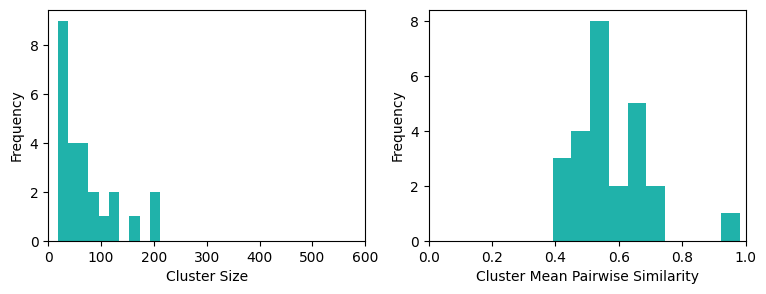

autbrick qwen noshortcontext kmeans


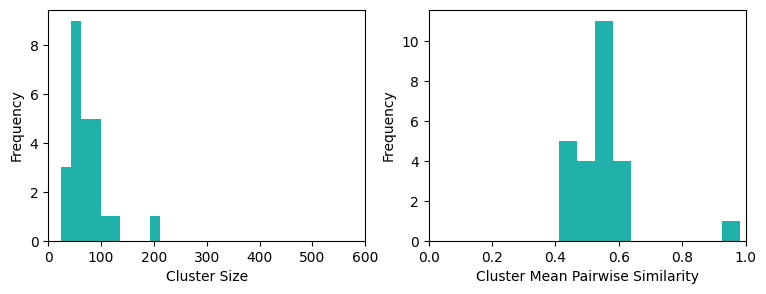

autbrick qwen nearshortcontext hier


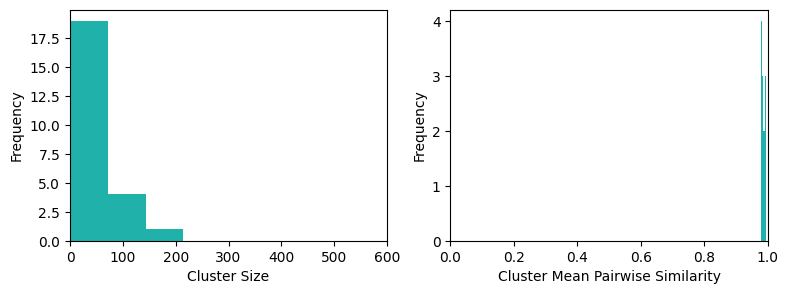

autbrick qwen nearshortcontext kmeans


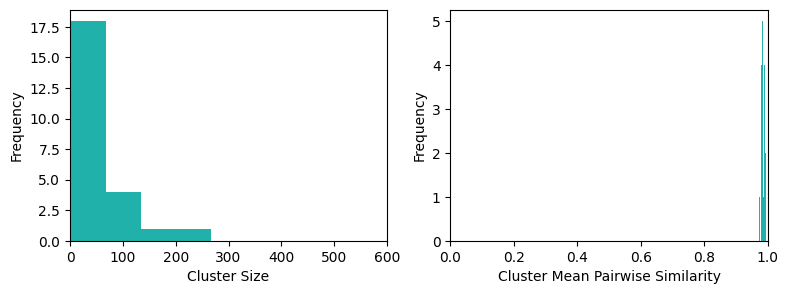

autbrick qwen farshortcontext hier


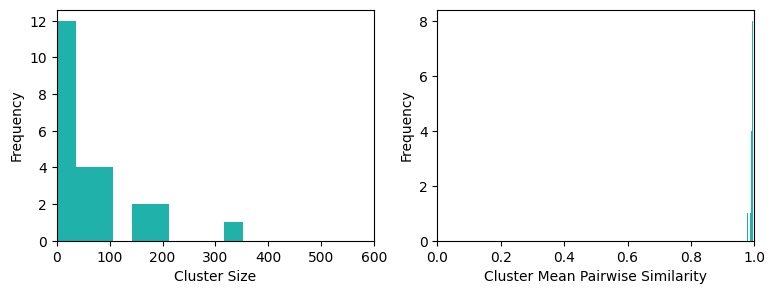

autbrick qwen farshortcontext kmeans


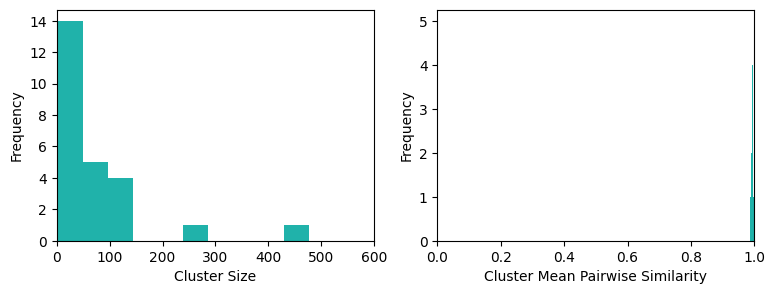

autbrick stella noshortcontext hier


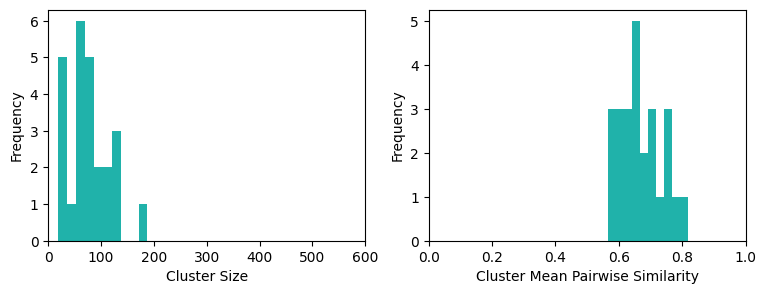

autbrick stella noshortcontext kmeans


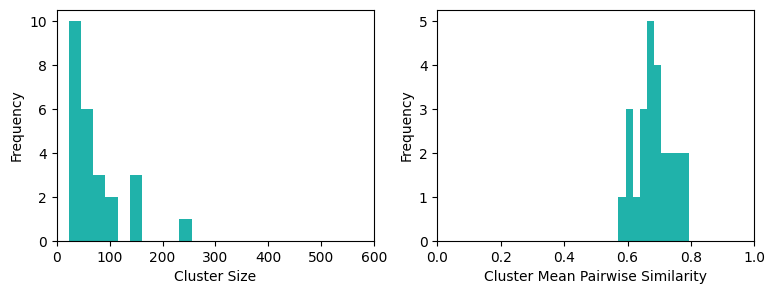

autbrick stella nearshortcontext hier


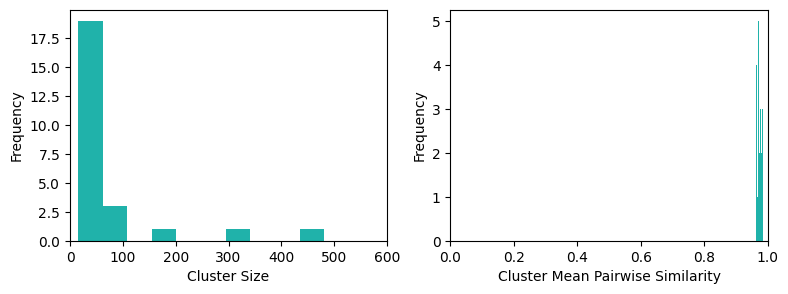

autbrick stella nearshortcontext kmeans


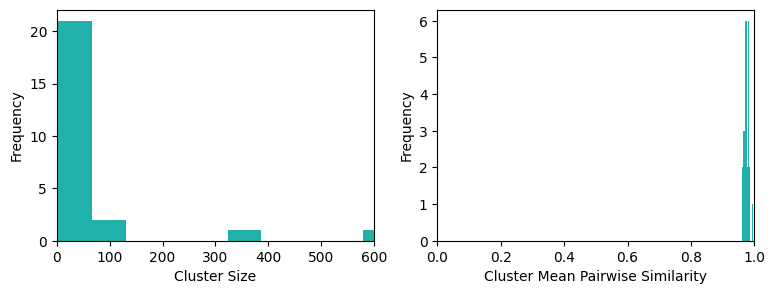

autbrick stella farshortcontext hier


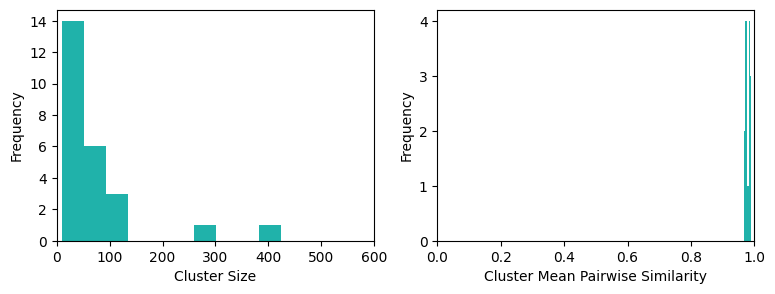

autbrick stella farshortcontext kmeans


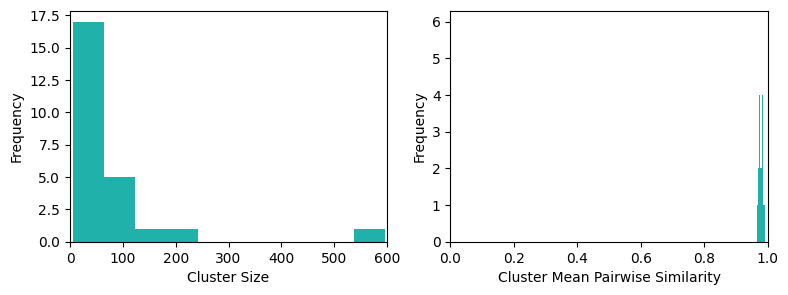

autbrick gtelarge noshortcontext hier


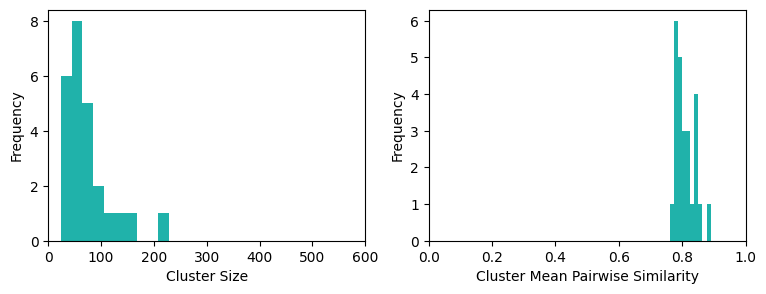

autbrick gtelarge noshortcontext kmeans


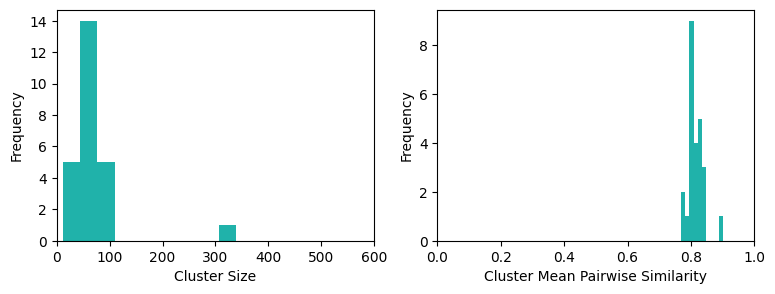

autbrick gtelarge nearshortcontext hier


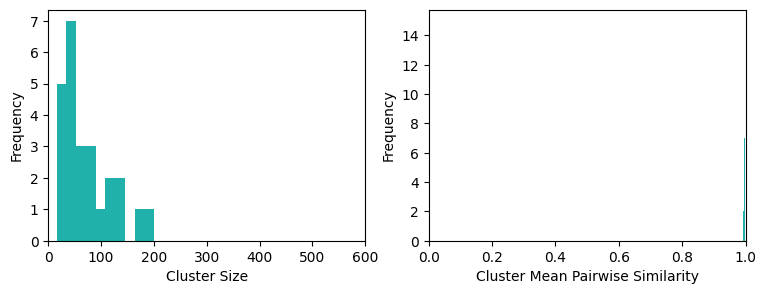

autbrick gtelarge nearshortcontext kmeans


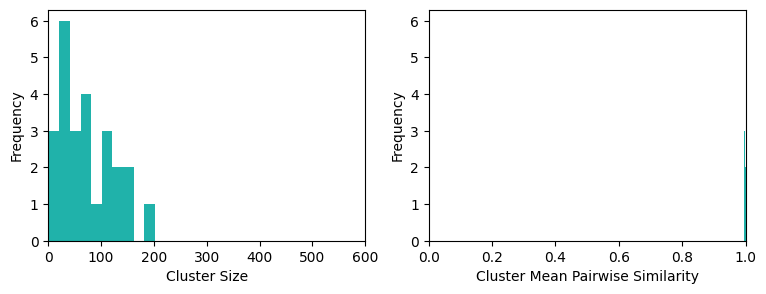

autbrick gtelarge farshortcontext hier


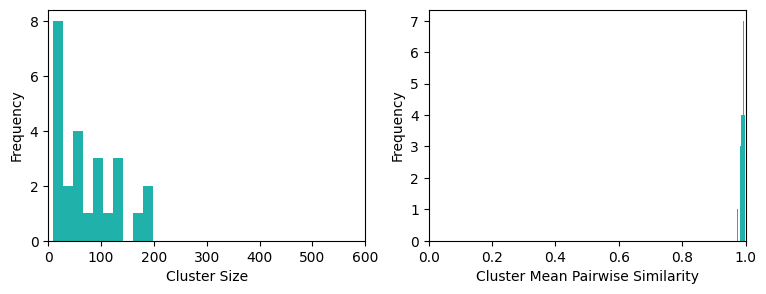

autbrick gtelarge farshortcontext kmeans


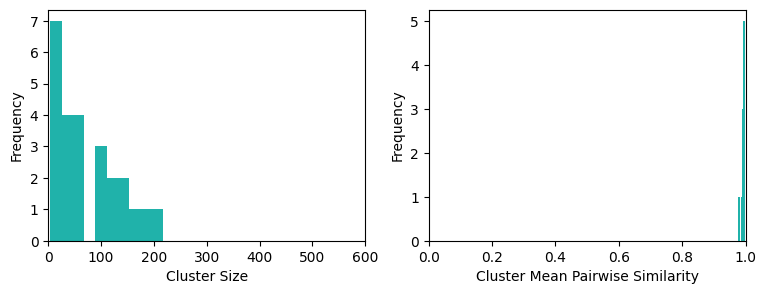

autbrick jxm noshortcontext hier


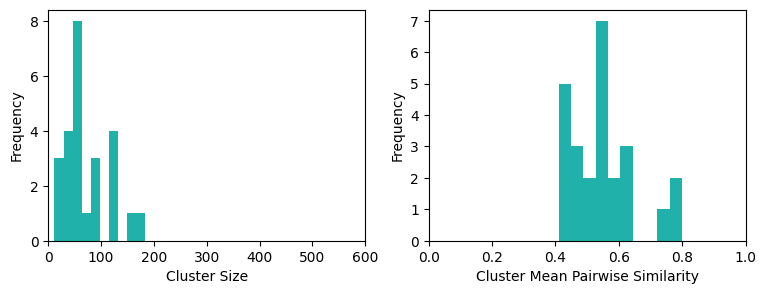

autbrick jxm noshortcontext kmeans


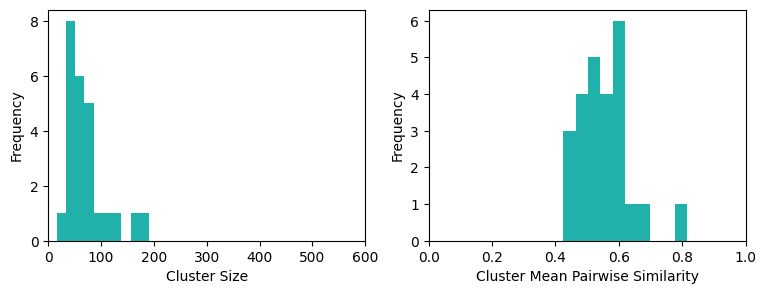

/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7963/1289264506.py:133: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"jump_cat_{model}_{context}_{algo}"] = (~(data[f"category_{model}_{context}_{algo}"].diff() == 0)).astype(int)
/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7963/1289264506.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"jump_SS_{model}_{context}_{algo}"] = (data[f"SS_{model}_{context}_{algo}"] < 0.8).astype(int)
/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel

autbrick jxm nearshortcontext hier


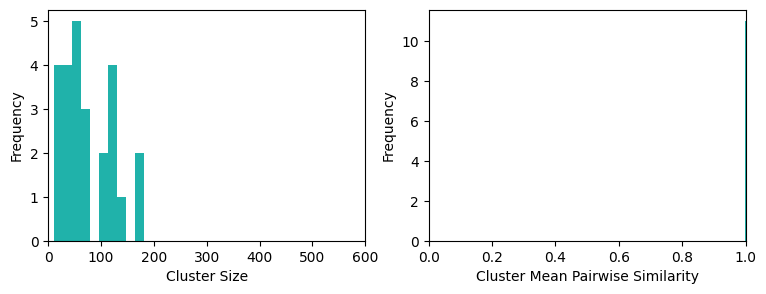

/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7963/1289264506.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"category_{model}_{context}_{algo}"] = data[data["task"] == taskid]["response"].apply(lambda x: response_to_cluster.get(x))
/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7963/1289264506.py:131: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"SS_{model}_{context}_{algo}"] = data[data["task"] == taskid].apply(lambda row: calc

autbrick jxm nearshortcontext kmeans


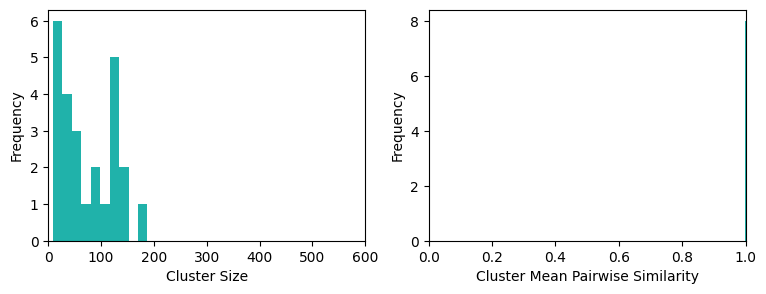

/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7963/1289264506.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"category_{model}_{context}_{algo}"] = data[data["task"] == taskid]["response"].apply(lambda x: response_to_cluster.get(x))
/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7963/1289264506.py:131: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"SS_{model}_{context}_{algo}"] = data[data["task"] == taskid].apply(lambda row: calc

autbrick jxm farshortcontext hier


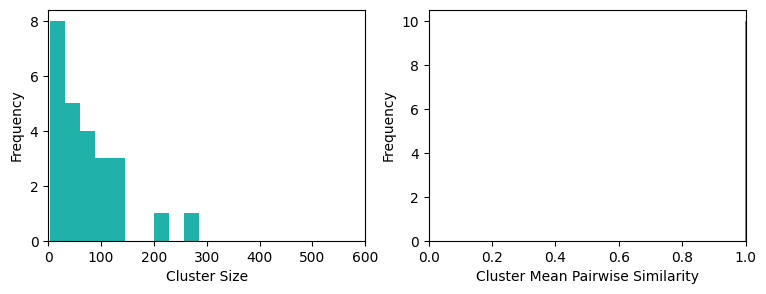

/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7963/1289264506.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"category_{model}_{context}_{algo}"] = data[data["task"] == taskid]["response"].apply(lambda x: response_to_cluster.get(x))
/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7963/1289264506.py:131: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"SS_{model}_{context}_{algo}"] = data[data["task"] == taskid].apply(lambda row: calc

autbrick jxm farshortcontext kmeans


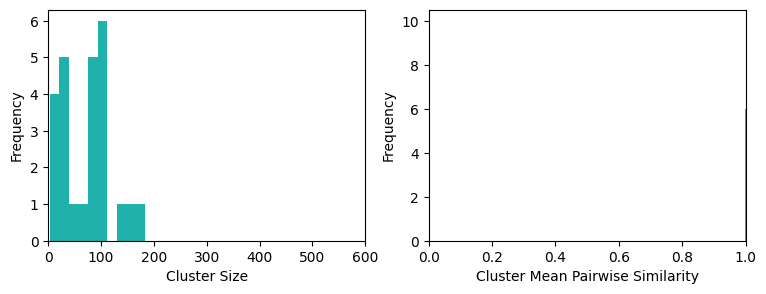

/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7963/1289264506.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"category_{model}_{context}_{algo}"] = data[data["task"] == taskid]["response"].apply(lambda x: response_to_cluster.get(x))
/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7963/1289264506.py:131: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"SS_{model}_{context}_{algo}"] = data[data["task"] == taskid].apply(lambda row: calc

autpaperclip qwen noshortcontext hier


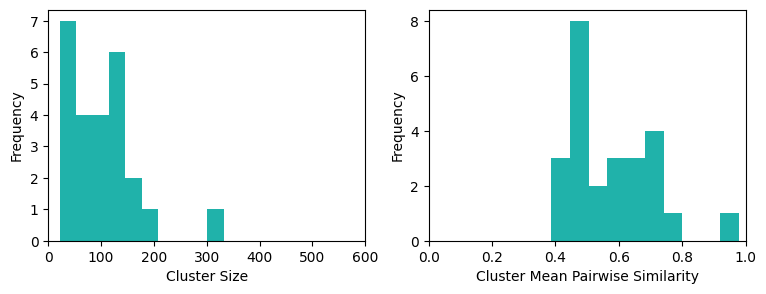

autpaperclip qwen noshortcontext kmeans


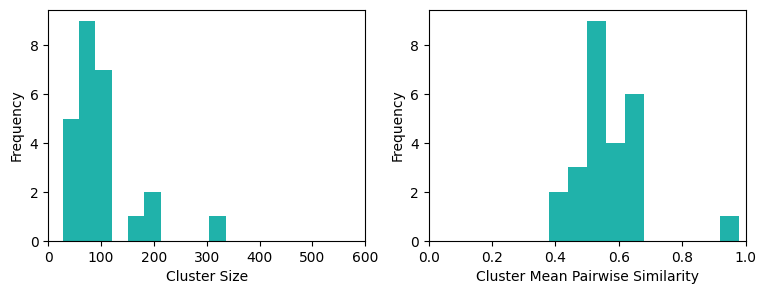

autpaperclip qwen nearshortcontext hier


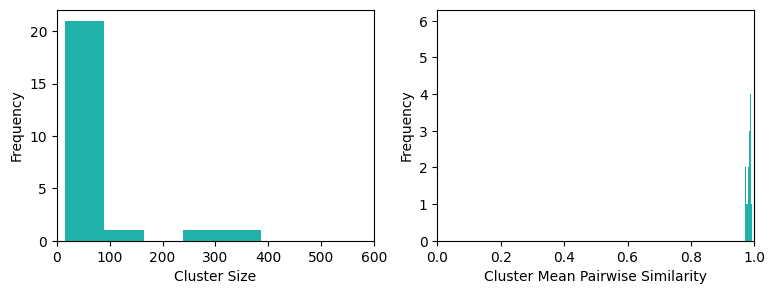

autpaperclip qwen nearshortcontext kmeans


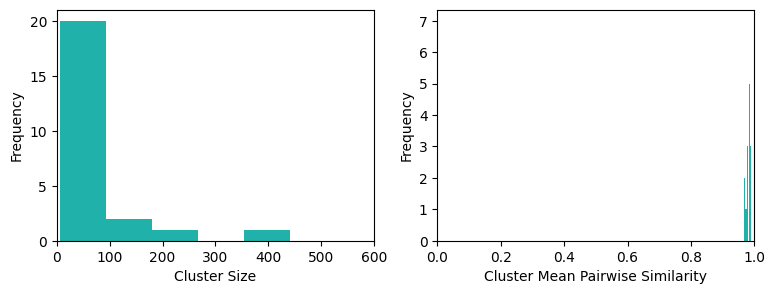

autpaperclip qwen farshortcontext hier


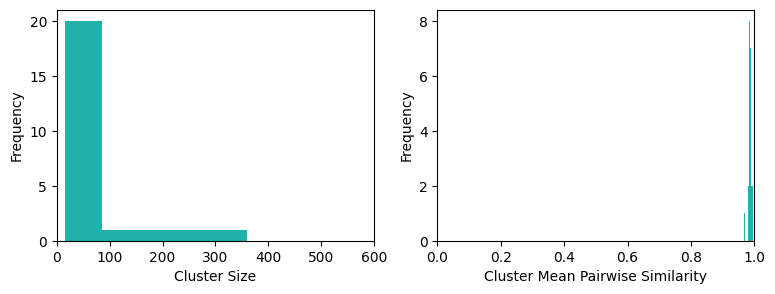

autpaperclip qwen farshortcontext kmeans


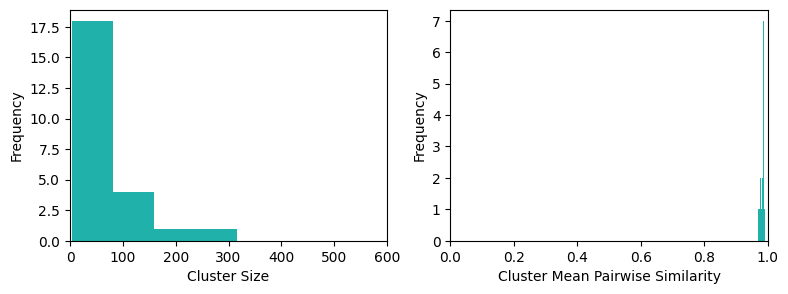

autpaperclip stella noshortcontext hier


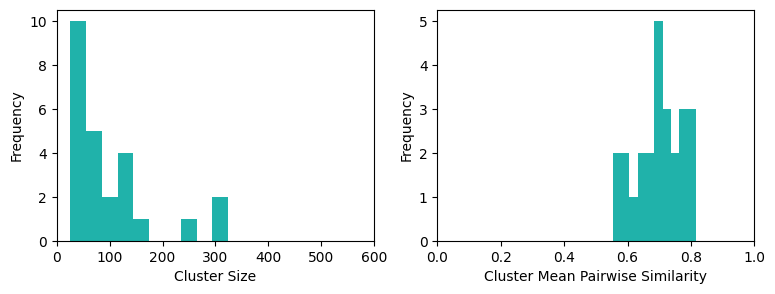

autpaperclip stella noshortcontext kmeans


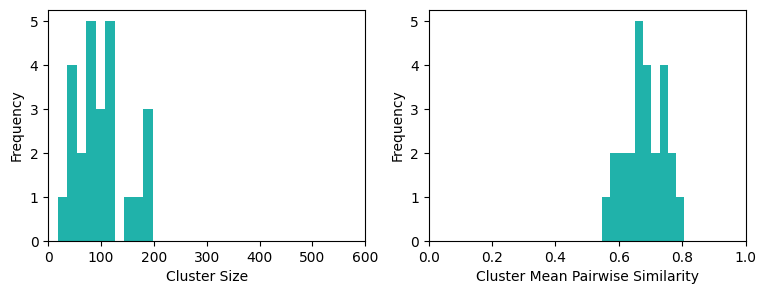

autpaperclip stella nearshortcontext hier


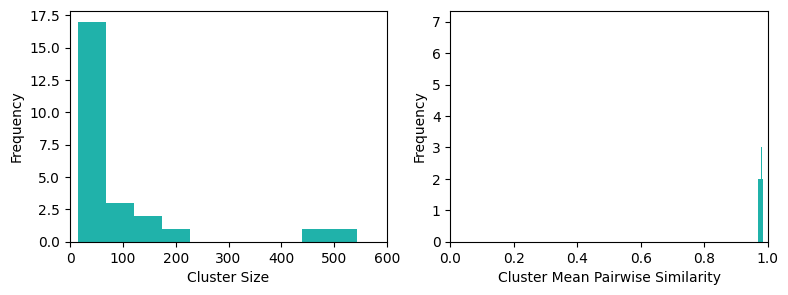

autpaperclip stella nearshortcontext kmeans


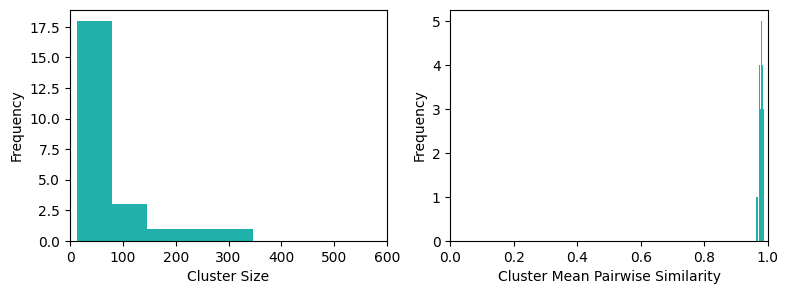

autpaperclip stella farshortcontext hier


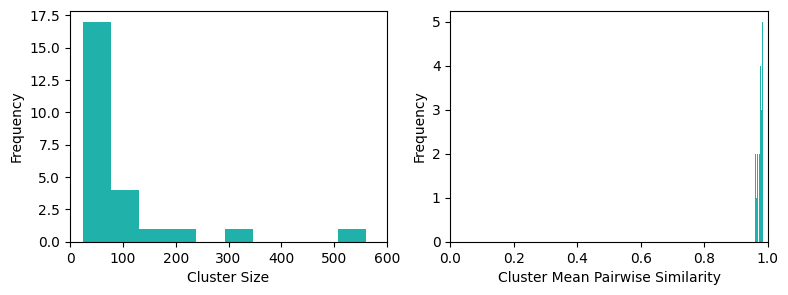

autpaperclip stella farshortcontext kmeans


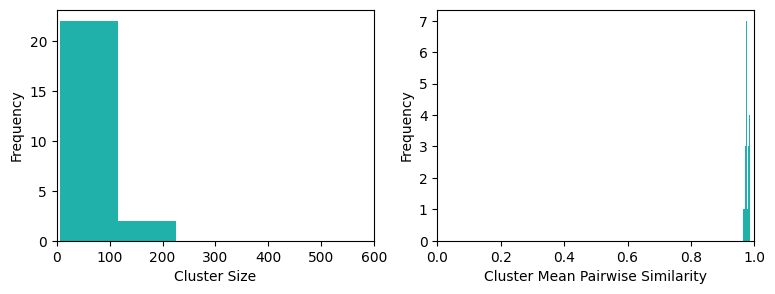

autpaperclip gtelarge noshortcontext hier


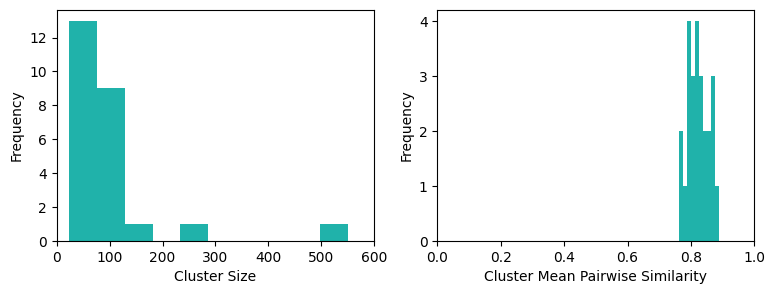

autpaperclip gtelarge noshortcontext kmeans


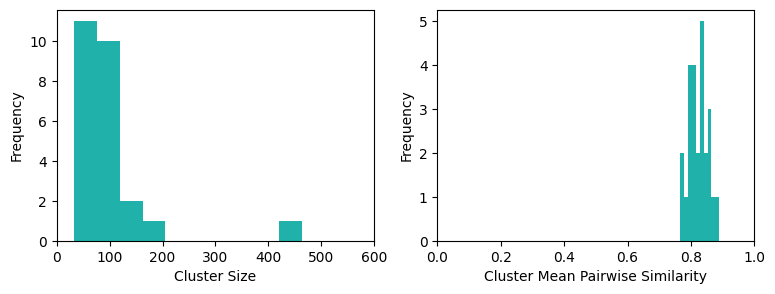

autpaperclip gtelarge nearshortcontext hier


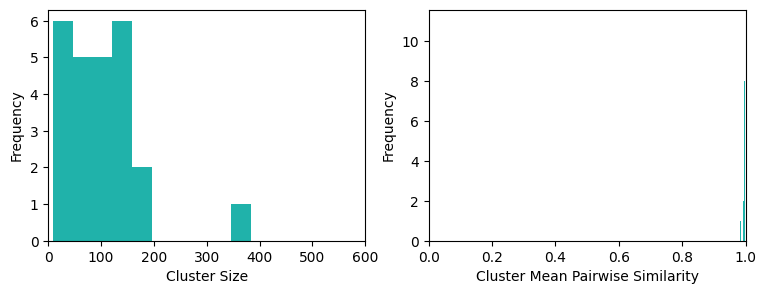

autpaperclip gtelarge nearshortcontext kmeans


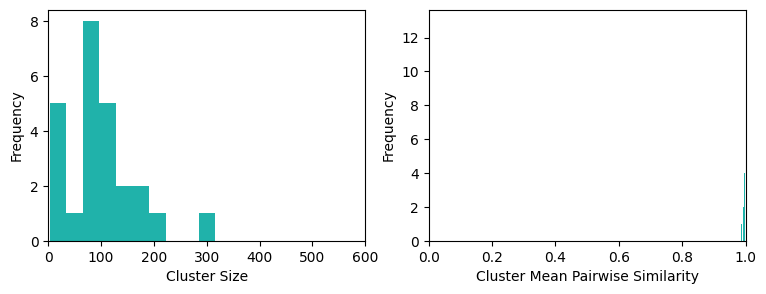

autpaperclip gtelarge farshortcontext hier


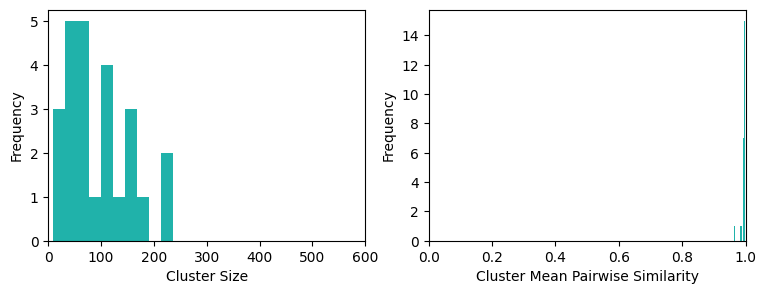

autpaperclip gtelarge farshortcontext kmeans


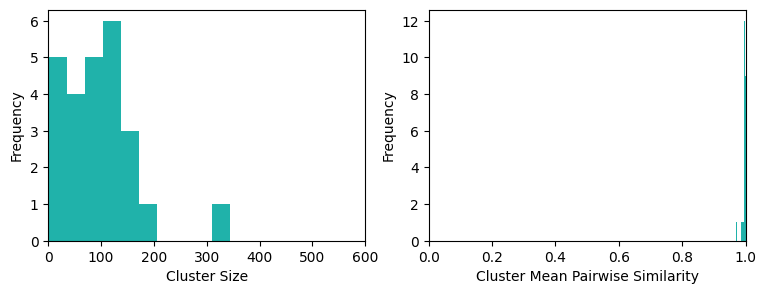

autpaperclip jxm noshortcontext hier


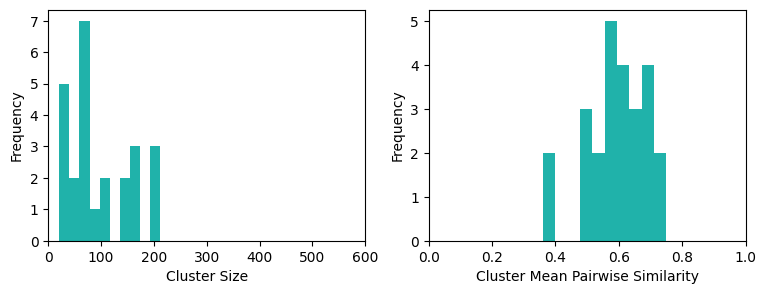

autpaperclip jxm noshortcontext kmeans


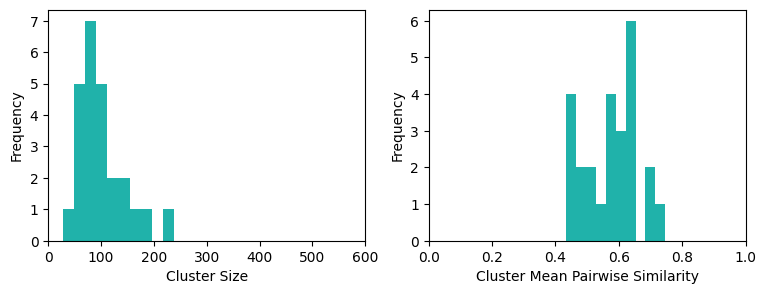

autpaperclip jxm nearshortcontext hier


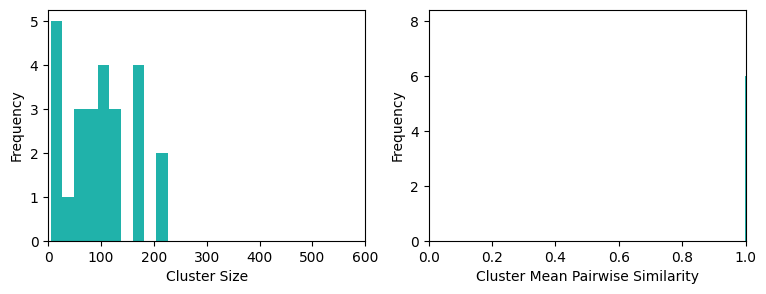

autpaperclip jxm nearshortcontext kmeans


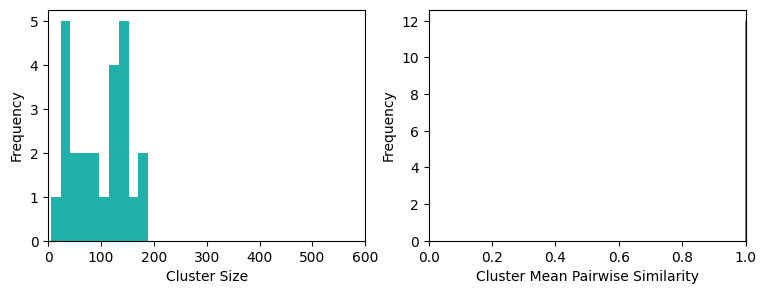

autpaperclip jxm farshortcontext hier


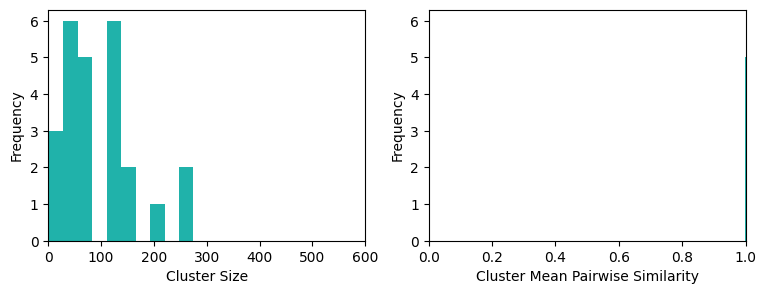

autpaperclip jxm farshortcontext kmeans


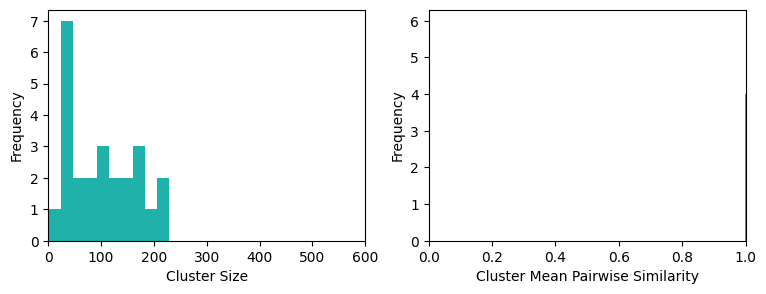

vf qwen noshortcontext hier


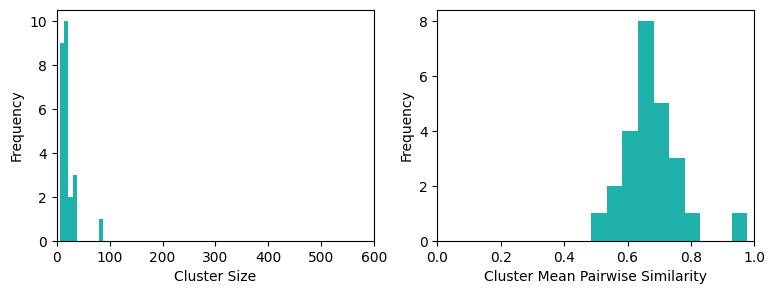

vf qwen noshortcontext kmeans


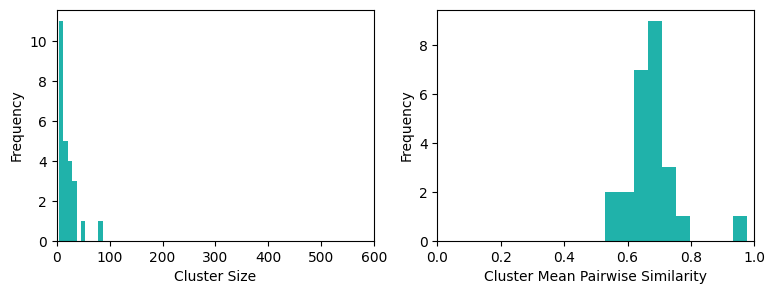

vf qwen nearshortcontext hier


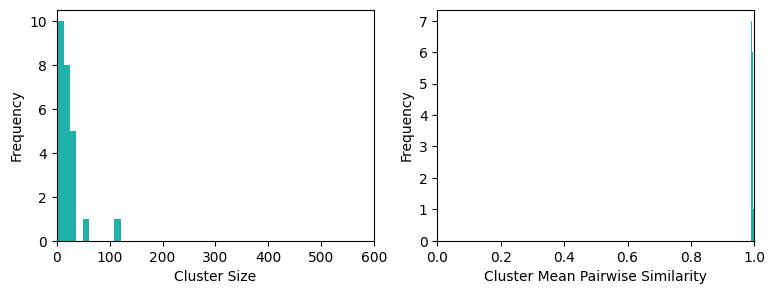

vf qwen nearshortcontext kmeans


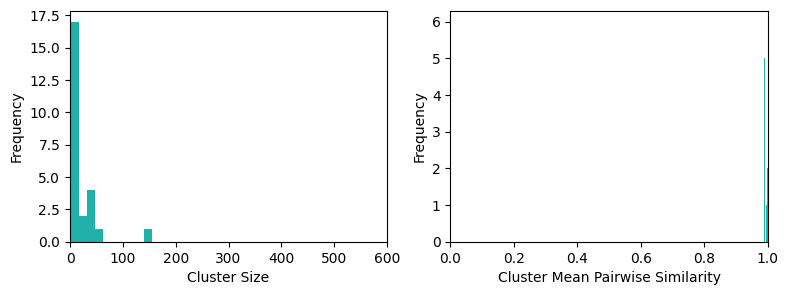

vf qwen farshortcontext hier


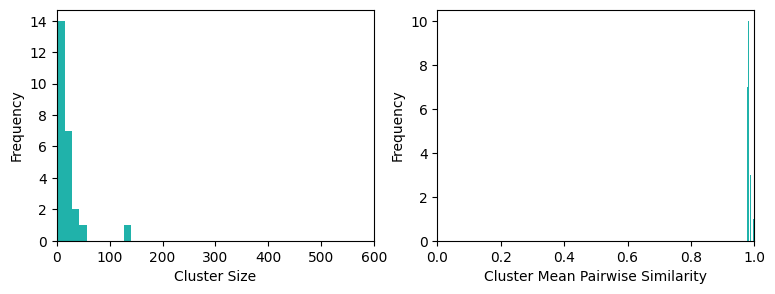

vf qwen farshortcontext kmeans


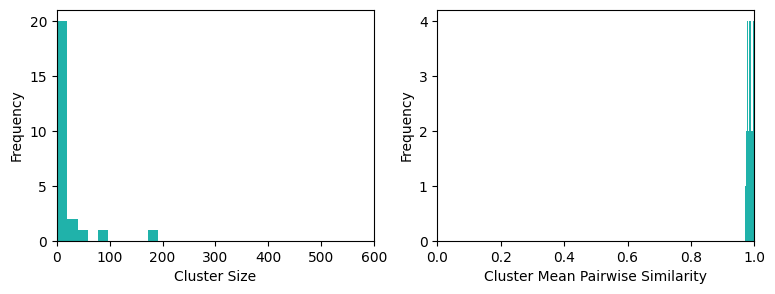

vf stella noshortcontext hier


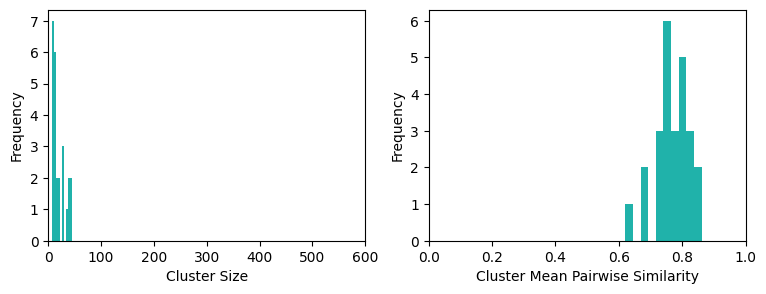

vf stella noshortcontext kmeans


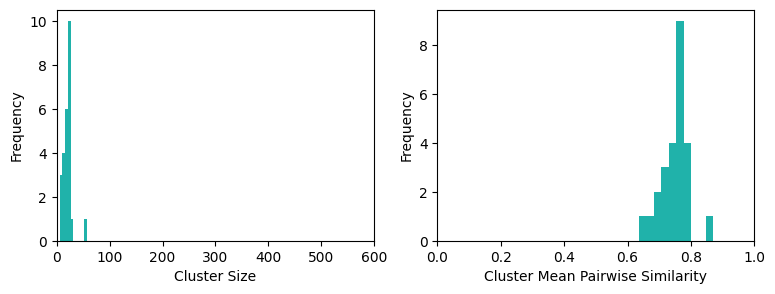

vf stella nearshortcontext hier


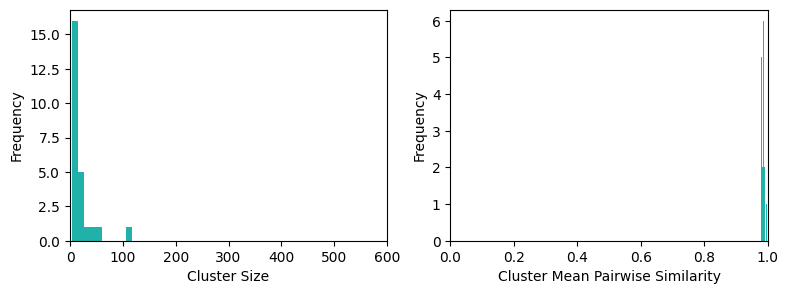

vf stella nearshortcontext kmeans


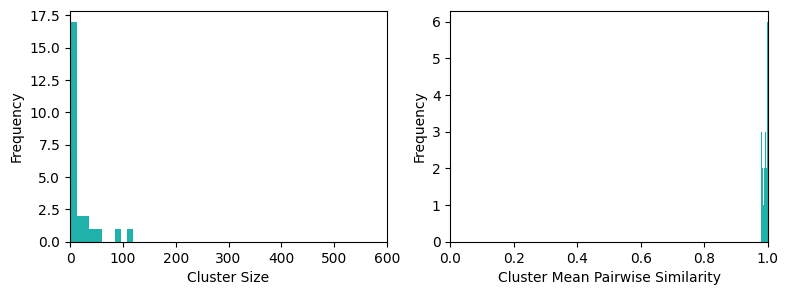

vf stella farshortcontext hier


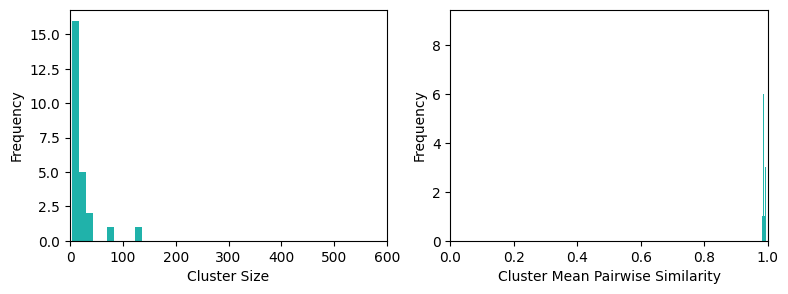

vf stella farshortcontext kmeans


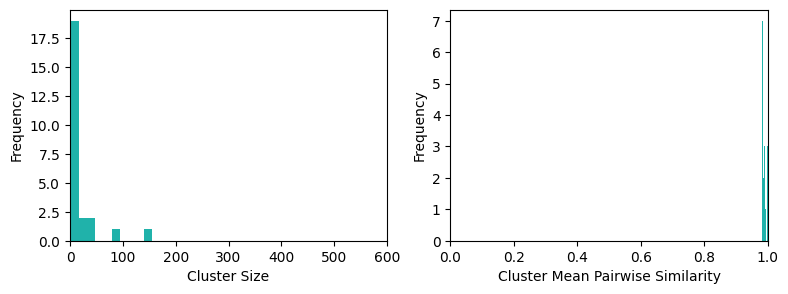

vf gtelarge noshortcontext hier


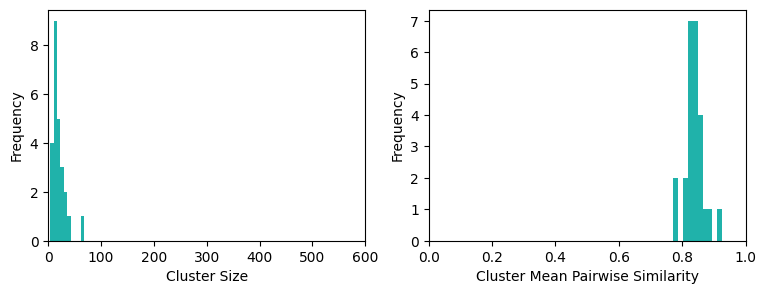

vf gtelarge noshortcontext kmeans


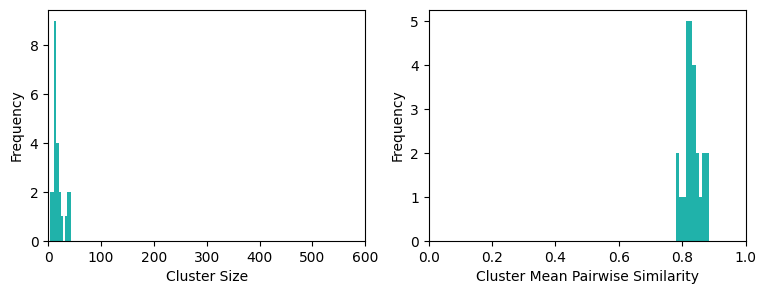

vf gtelarge nearshortcontext hier


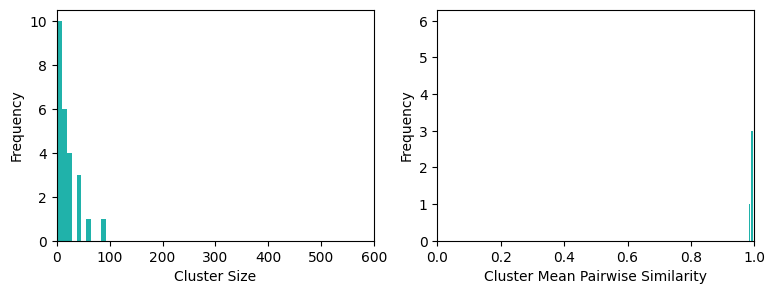

vf gtelarge nearshortcontext kmeans


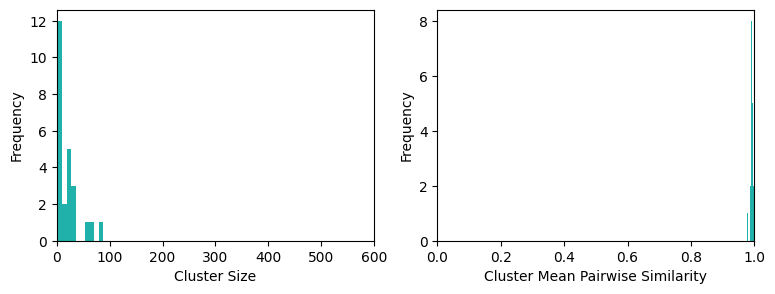

vf gtelarge farshortcontext hier


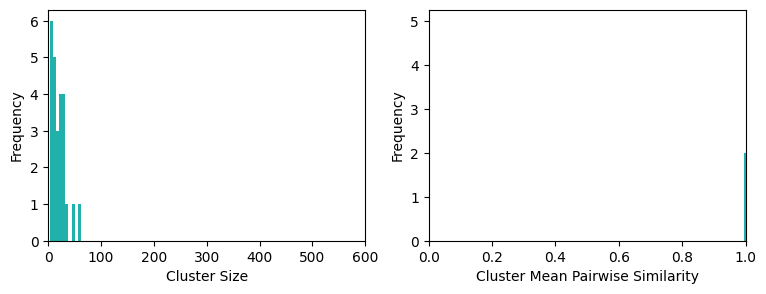

vf gtelarge farshortcontext kmeans


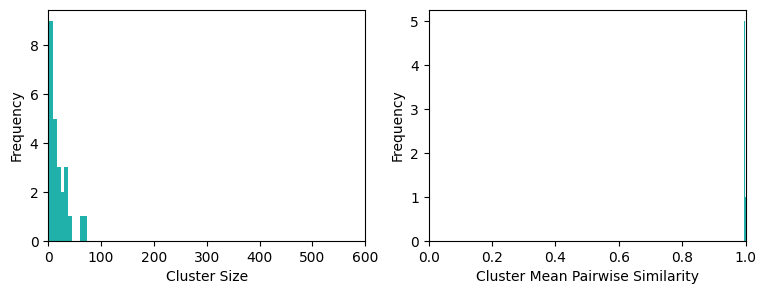

vf jxm noshortcontext hier


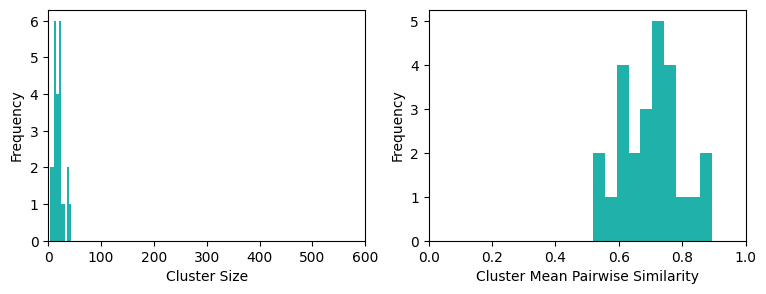

vf jxm noshortcontext kmeans


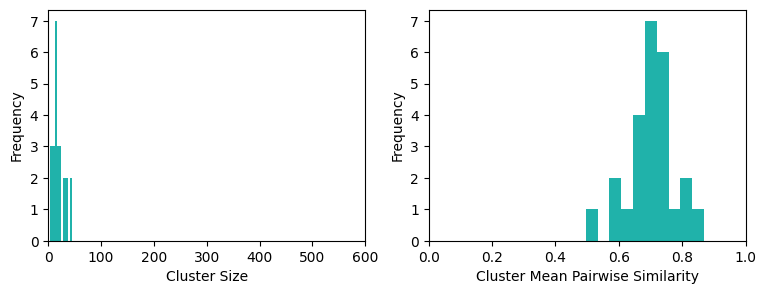

vf jxm nearshortcontext hier


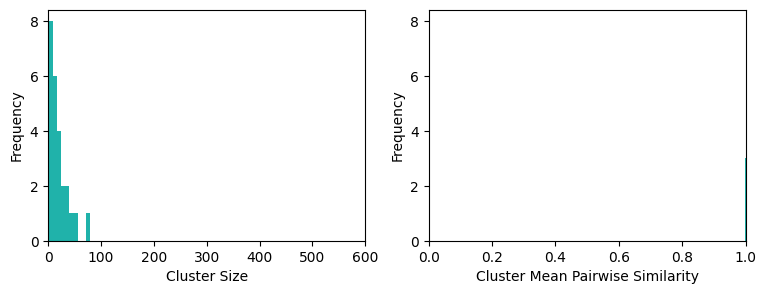

vf jxm nearshortcontext kmeans


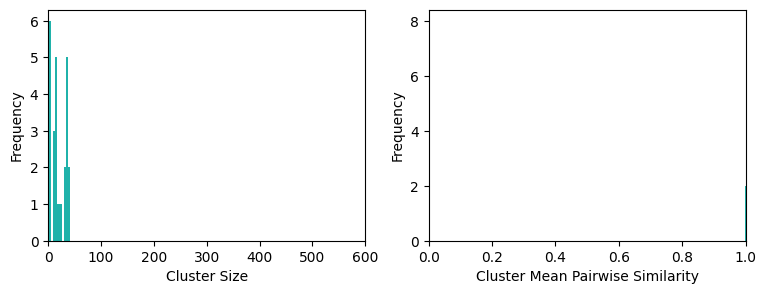

vf jxm farshortcontext hier


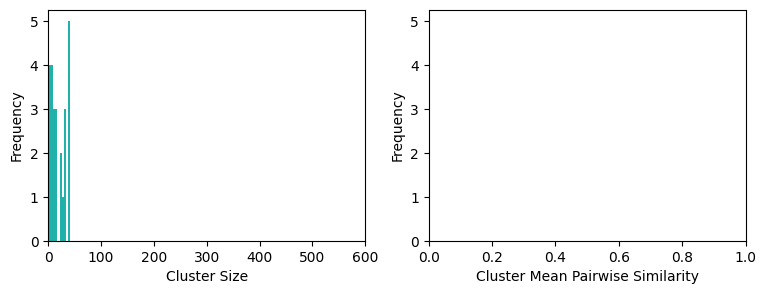

vf jxm farshortcontext kmeans


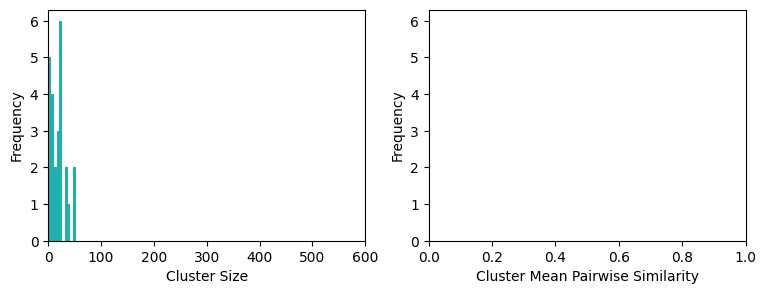

In [6]:
clustering_info = {}
for i, textset in enumerate(texts):
    for model in models:
        for context in contexts:
            for algo in algos:
                print(tasks[i], model, context, algo)
                embeddings = pk.load(open(f"../embeddings/embeddings_{model}_{tasks[i]}_{context}.pk", "rb"))
                if algo == "hier":
                    response_to_cluster, cluster_to_response, num_clusters, minsim, meansim = perform_hierarchicalClustering(list(embeddings.values()), textset, ("maxclust", 25), printclusters)    # or ("distance", 1.89)
                elif algo == "kmeans":
                    response_to_cluster, cluster_to_response, num_clusters, minsim, meansim = permform_KMeans(list(embeddings.values()), textset, ("maxclust", 25), printclusters)    # or ("distance", 1.89)

                # print("Num clusters =", num_clusters)     # 25
                clustering_info[f"{tasks[i]}_{model}_{context}_{algo}"] = {"response_to_cluster": response_to_cluster, "cluster_to_response": cluster_to_response}
                write_category_SS_jump(taskid[i], model, context, algo, embeddings, response_to_cluster)

In [7]:
i = 0
d = {}
for task in tasks:
    for model in models:
        for context in contexts:
            for algo in algos:
                d[i] = f"{task}_{model}_{context}_{algo}" 
                i += 1

total_combinations = len(tasks) * len(models) * len(contexts) * len(algos)
agreement_matrix = np.empty((total_combinations, total_combinations), dtype=object)

for i in range(total_combinations):
    for j in range(i, total_combinations):
        task1, model1, context1, algo1 = d[i].split("_")
        task2, model2, context2, algo2 = d[j].split("_")
        try:
            cluster1 = data[data["task"] == task_to_id[task1]][f"category_{model1}_{context1}_{algo1}"]
            cluster2 = data[data["task"] == task_to_id[task2]][f"category_{model2}_{context2}_{algo2}"]
            agreement_matrix[i, j] = get_cluster_agreement(cluster1, cluster2)
        except:
            agreement_matrix[i, j] = "NA"

In [8]:
df = pd.DataFrame(agreement_matrix, index=[d[i] for i in range(total_combinations)], columns=[d[i] for i in range(total_combinations)])
html = df.to_html(classes="table table-striped table-bordered", index=True)

# Add CSS for freezing the header and the first column
style = """
    <style>
        .dataframe tbody tr th {
            position: sticky;
            left: 0;
            background-color: #000000;
            z-index: 1;
        }
        .dataframe thead th {
            position: sticky;
            top: 0;
            background-color: #000000;
            z-index: 2;
        }
        .dataframe {
            width: 100%;
            height: 400px;
            overflow: auto;
            display: block;
        }
    </style>
"""

# Display the styled DataFrame with frozen header and first column
display(HTML(style + html))

,autbrick_qwen_noshortcontext_hier,autbrick_qwen_noshortcontext_kmeans,autbrick_qwen_nearshortcontext_hier,autbrick_qwen_nearshortcontext_kmeans,autbrick_qwen_farshortcontext_hier,autbrick_qwen_farshortcontext_kmeans,autbrick_stella_noshortcontext_hier,autbrick_stella_noshortcontext_kmeans,autbrick_stella_nearshortcontext_hier,autbrick_stella_nearshortcontext_kmeans,autbrick_stella_farshortcontext_hier,autbrick_stella_farshortcontext_kmeans,autbrick_gtelarge_noshortcontext_hier,autbrick_gtelarge_noshortcontext_kmeans,autbrick_gtelarge_nearshortcontext_hier,autbrick_gtelarge_nearshortcontext_kmeans,autbrick_gtelarge_farshortcontext_hier,autbrick_gtelarge_farshortcontext_kmeans,autbrick_jxm_noshortcontext_hier,autbrick_jxm_noshortcontext_kmeans,autbrick_jxm_nearshortcontext_hier,autbrick_jxm_nearshortcontext_kmeans,autbrick_jxm_farshortcontext_hier,autbrick_jxm_farshortcontext_kmeans,autpaperclip_qwen_noshortcontext_hier,autpaperclip_qwen_noshortcontext_kmeans,autpaperclip_qwen_nearshortcontext_hier,autpaperclip_qwen_nearshortcontext_kmeans,autpaperclip_qwen_farshortcontext_hier,autpaperclip_qwen_farshortcontext_kmeans,autpaperclip_stella_noshortcontext_hier,autpaperclip_stella_noshortcontext_kmeans,autpaperclip_stella_nearshortcontext_hier,autpaperclip_stella_nearshortcontext_kmeans,autpaperclip_stella_farshortcontext_hier,autpaperclip_stella_farshortcontext_kmeans,autpaperclip_gtelarge_noshortcontext_hier,autpaperclip_gtelarge_noshortcontext_kmeans,autpaperclip_gtelarge_nearshortcontext_hier,autpaperclip_gtelarge_nearshortcontext_kmeans,autpaperclip_gtelarge_farshortcontext_hier,autpaperclip_gtelarge_farshortcontext_kmeans,autpaperclip_jxm_noshortcontext_hier,autpaperclip_jxm_noshortcontext_kmeans,autpaperclip_jxm_nearshortcontext_hier,autpaperclip_jxm_nearshortcontext_kmeans,autpaperclip_jxm_farshortcontext_hier,autpaperclip_jxm_farshortcontext_kmeans,vf_qwen_noshortcontext_hier,vf_qwen_noshortcontext_kmeans,vf_qwen_nearshortcontext_hier,vf_qwen_nearshortcontext_kmeans,vf_qwen_farshortcontext_hier,vf_qwen_farshortcontext_kmeans,vf_stella_noshortcontext_hier,vf_stella_noshortcontext_kmeans,vf_stella_nearshortcontext_hier,vf_stella_nearshortcontext_kmeans,vf_stella_farshortcontext_hier,vf_stella_farshortcontext_kmeans,vf_gtelarge_noshortcontext_hier,vf_gtelarge_noshortcontext_kmeans,vf_gtelarge_nearshortcontext_hier,vf_gtelarge_nearshortcontext_kmeans,vf_gtelarge_farshortcontext_hier,vf_gtelarge_farshortcontext_kmeans,vf_jxm_noshortcontext_hier,vf_jxm_noshortcontext_kmeans,vf_jxm_nearshortcontext_hier,vf_jxm_nearshortcontext_kmeans,vf_jxm_farshortcontext_hier,vf_jxm_farshortcontext_kmeans
autbrick_qwen_noshortcontext_hier,"1.0, 1.0, 1.0, 1.0, 1.0","0.8, 0.7, 0.7, 0.7, 0.7","0.2, 0.4, 0.4, 0.4, 0.4","0.2, 0.4, 0.3, 0.4, 0.4","0.2, 0.4, 0.4, 0.4, 0.4","0.4, 0.5, 0.4, 0.5, 0.5","0.1, 0.5, 0.5, 0.5, 0.5","0.2, 0.5, 0.5, 0.5, 0.5","0.2, 0.4, 0.4, 0.5, 0.4","0.2, 0.4, 0.4, 0.5, 0.4","0.1, 0.4, 0.4, 0.4, 0.4","0.2, 0.4, 0.4, 0.5, 0.4","0.1, 0.5, 0.5, 0.4, 0.5","0.2, 0.4, 0.4, 0.4, 0.4","0.1, 0.2, 0.2, 0.2, 0.2","0.1, 0.2, 0.2, 0.2, 0.2","0.1, 0.2, 0.2, 0.2, 0.2","0.1, 0.2, 0.2, 0.2, 0.2","0.1, 0.3, 0.3, 0.3, 0.3","0.2, 0.3, 0.3, 0.3, 0.3","0.1, 0.3, 0.3, 0.3, 0.3","0.2, 0.3, 0.3, 0.3, 0.3","0.2, 0.3, 0.3, 0.3, 0.3","0.2, 0.3, 0.3, 0.3, 0.3",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
autbrick_qwen_noshortcontext_kmeans,None,"1.0, 1.0, 1.0, 1.0, 1.0","0.1, 0.4, 0.3, 0.4, 0.4","0.2, 0.4, 0.3, 0.4, 0.4","0.2, 0.4, 0.4, 0.4, 0.4","0.4, 0.5, 0.4, 0.5, 0.5","0.1, 0.4, 0.5, 0.4, 0.4","0.2, 0.5, 0.5, 0.5, 0.5","0.2, 0.4, 0.4, 0.4, 0.4","0.2, 0.4, 0.4, 0.5, 0.4","0.1, 0.4, 0.4, 0.4, 0.4","0.2, 0.5, 0.4, 0.5, 0.5","0.1, 0.4, 0.4, 0.4, 0.4","0.2, 0.5, 0.5, 0.5, 0.5","0.1, 0.2, 0.2, 0.2, 0.2","0.1, 0.2, 0.2, 0.2, 0.2","0.1, 0.2, 0.2, 0.2, 0.2","0.1, 0.2, 0.2, 0.2, 0.2","0.1, 0.3, 0.3, 0.3, 0.3","0.2, 0.3, 0.3, 0.3, 0.3","0.1, 0.3, 0.3, 0.3, 0.3","0

In [10]:
taskid = 2
model1 = "gtelarge"
context1 = "noshortcontext"
algo1 = "hier"
model2 = "gtelarge"
context2 = "noshortcontext"
algo2 = "kmeans"

get_cluster_agreement(data[data["task"] == taskid][f"category_{model1}_{context1}_{algo1}"], data[data["task"] == taskid][f"category_{model2}_{context2}_{algo2}"])

'0.3, 0.6, 0.5, 0.6, 0.6'